# Clasificación de personas en situación de pobreza

In [1]:
# !pip install xgboost
# !pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve
)

# Clasificadores
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.random import set_seed

import warnings
warnings.simplefilter("ignore")

In [2]:
dta = pd.read_csv("./data/data_f.csv", index_col=0)
dta.head()

,edad,hombre,est_sup,colegio_priv,gran_empresa,segundo_trab,ingbrut,urbano,no_pobre
1,28.0,0.0,1.0,0.0,0.0,1.0,1454.500000,1.0,1.0
2,48.0,0.0,0.0,0.0,0.0,1.0,2037.000000,1.0,1.0
3,25.0,0.0,0.0,0.0,0.0,0.0,2037.000000,1.0,1.0
4,16.0,0.0,0.0,0.0,0.0,0.0,2037.000000,1.0,1.0
6,41.0,0.0,0.0,0.0,0.0,1.0,1842.066732,1.0,1.0


## Split y estandarización
Primero definimos las variables que tendremos como explicativas y al target

In [3]:
dta = dta.loc[(dta["ingbrut"] > 0)]
dta["lning"] = np.log(dta["ingbrut"])
X_names = ["edad", "hombre", "est_sup", "colegio_priv", "gran_empresa", "segundo_trab", "urbano", "lning"]
X = dta[X_names]
y = dta["no_pobre"]

# Estandarización
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Visualizaciones

In [4]:
print(f"La distribución de la variable `no pobre` es:\n{y.value_counts()}\n")
print(f"La distribución de la variable `no pobre` de entrenamiento es:\n{y_train.value_counts()}\n")
print(f"La distribución de la variable `no pobre` de testing es:\n{y_test.value_counts()}\n")

La distribución de la variable `no pobre` es:
1.0    67059
0.0    13343
Name: no_pobre, dtype: int64

La distribución de la variable `no pobre` de entrenamiento es:
1.0    53686
0.0    10635
Name: no_pobre, dtype: int64

La distribución de la variable `no pobre` de testing es:
1.0    13373
0.0     2708
Name: no_pobre, dtype: int64



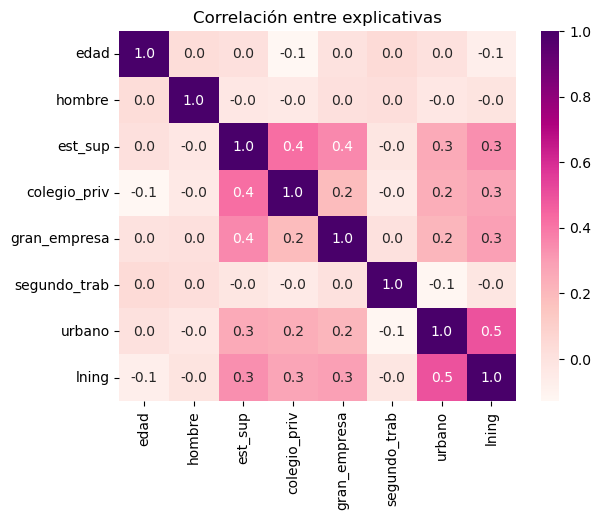

In [5]:
plt.plot()
correl = pd.DataFrame(X, columns=X_names).corr()

sns.heatmap(correl, annot=True, fmt = ".1f", cmap="RdPu")
plt.xticks(rotation=90)

plt.title("Correlación entre explicativas")
plt.show()

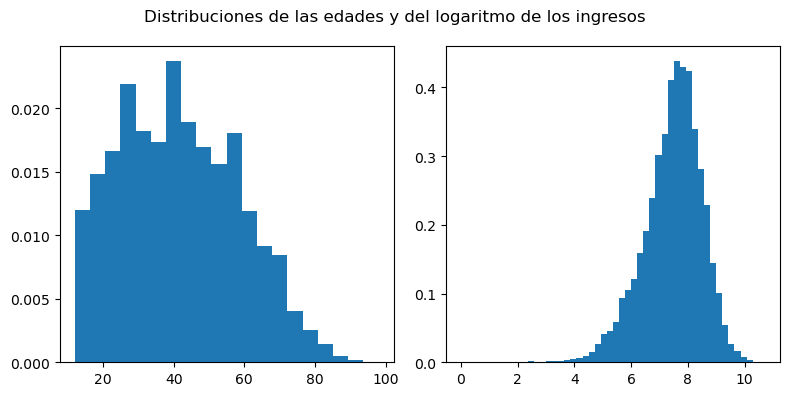

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

axes[0].hist(dta["edad"], bins=20, density=True)
axes[1].hist(dta["lning"], bins=50, density=True)

fig.suptitle("Distribuciones de las edades y del logaritmo de los ingresos")

plt.savefig("./figures/distribuciones.pdf")
plt.show()

## Relaciones entre las variables
Para poder encontrar relaciones entre las variables, debido a que los modelos de clasificación no necesariante tienen ese objetivo. se puede estimar un modelo Logit

In [7]:
model = sm.Logit(y, X)
results = model.fit()

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.642646
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               no_pobre   No. Observations:                80402
Model:                          Logit   Df Residuals:                    80394
Method:                           MLE   Df Model:                            7
Date:                Thu, 16 Feb 2023   Pseudo R-squ.:                 -0.4300
Time:                        03:14:58   Log-Likelihood:                -51670.
converged:                       True   LL-Null:                       -36134.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1640      0.008     21.550      0.000       0.149       0.179
x2            -0.0153      0.

In [8]:
AME = results.get_margeff(at="overall", method="dydx")

print(AME.summary())

        Logit Marginal Effects       
Dep. Variable:               no_pobre
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0370      0.002     21.783      0.000       0.034       0.040
x2            -0.0035      0.002     -2.058      0.040      -0.007      -0.000
x3             0.0060      0.002      3.026      0.002       0.002       0.010
x4             0.0177      0.002      9.337      0.000       0.014       0.021
x5             0.0005      0.002      0.278      0.781      -0.003       0.004
x6             0.0025      0.002      1.495      0.135      -0.001       0.006
x7             0.0425      0.002     22.114      0.000       0.039       0.046
x8             0.1190      0.002     58.347      0.000       0.115       0.123


Los resultados son interesantes:

* Las personas con mayor edad tienen menos probabilidad de ser probreza
* El ser hombre no reduce el nivel de pobreza, sino lo vuelve mas probable
* Tener un estudio superior (no universitario, universitario, maestria o doctorado) reduce los niveles de pobreza
* Haber estudiado en un colegio privado reduce la probabilidad de ser pobre
* Vivir en una zona urbana tambien reduce la probabilidad de ser pobre
* _El mas evidente_: recibir mayores ingresos tambien reduce la probabilidad de ser pobre

## Algoritmos
Se estimaron 9 algoritmos. Aquellos que dependen de los valores iniciales, se fijó un seed. Se usó cross-validation con Grid Search para conseguir el mejor modelo posible para cada algoritmo

### Modelo 1: Modelo lineal

In [9]:
ml = LinearRegression().fit(X_train, y_train)

yhat_proba_ml = ml.predict(X_test)
yhat_ml = (yhat_proba_ml >= 0.5).astype(int)

# Estadisticos
score_ml = accuracy_score(y_test, yhat_ml)
ps_ml = precision_score(y_test, yhat_ml)
r_ml = recall_score(y_test, yhat_ml)
f1_ml = f1_score(y_test, yhat_ml)

# Confusion matrix y ROC
conf_ml = confusion_matrix(y_test, yhat_ml, normalize="true")
report_ml = classification_report(y_test, yhat_ml)
fml, tml, thresholds = roc_curve(y_test, yhat_proba_ml)

print(report_ml)

              precision    recall  f1-score   support

         0.0       0.61      0.09      0.16      2708
         1.0       0.84      0.99      0.91     13373

    accuracy                           0.84     16081
   macro avg       0.73      0.54      0.53     16081
weighted avg       0.80      0.84      0.78     16081



### Modelo 2. Logistic Regression

In [10]:
lr = LogisticRegression(random_state=19).fit(X_train, y_train)

yhat_proba_lr = lr.predict_proba(X_test)[:,1]
yhat_lr = lr.predict(X_test)

# Estadisticos
score_lr = accuracy_score(y_test, yhat_lr)
ps_lr = precision_score(y_test, yhat_lr)
r_lr = recall_score(y_test, yhat_lr)
f1_lr = f1_score(y_test, yhat_lr)

# Confusion matrix y ROC
conf_lr = confusion_matrix(y_test, yhat_lr, normalize="true")
report_lr = classification_report(y_test, yhat_lr)
flr, tlr, thresholds = roc_curve(y_test, yhat_proba_lr)

print(report_lr)

              precision    recall  f1-score   support

         0.0       0.58      0.20      0.30      2708
         1.0       0.86      0.97      0.91     13373

    accuracy                           0.84     16081
   macro avg       0.72      0.59      0.61     16081
weighted avg       0.81      0.84      0.81     16081



### Modelo 3. K-Nearest Neighbours

In [11]:
# Grid Search: Cantidad de Neigbours
knn_grid_search = KNeighborsClassifier()
k_range = list(range(1, 26))
param_grid = {
    'n_neighbors': k_range,
    'weights': ["uniform"]
}

grid = GridSearchCV(
    knn_grid_search, param_grid, cv = 5, scoring = "accuracy",
    verbose = 10,  n_jobs = -1 # Paralelización
)

knn = grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [12]:
print(knn.best_params_)
print(knn.best_score_ )

{'n_neighbors': 25, 'weights': 'uniform'}
0.8450117356764565


In [13]:
yhat_proba_knn = knn.predict_proba(X_test)[:,1]
yhat_knn = knn.predict(X_test)

# Estadisticos
score_knn = accuracy_score(y_test, yhat_knn)
ps_knn = precision_score(y_test, yhat_knn)
r_knn = recall_score(y_test, yhat_knn)
f1_knn = f1_score(y_test, yhat_knn)

# Confusion matrix y ROC
conf_knn = confusion_matrix(y_test, yhat_knn, normalize="true")
report_knn = classification_report(y_test, yhat_knn)
fknn, tknn, thresholds = roc_curve(y_test, yhat_proba_knn)

print(report_knn)

              precision    recall  f1-score   support

         0.0       0.56      0.26      0.35      2708
         1.0       0.86      0.96      0.91     13373

    accuracy                           0.84     16081
   macro avg       0.71      0.61      0.63     16081
weighted avg       0.81      0.84      0.81     16081



### Modelo 4. Decision Tree

In [14]:
# Grid Search: Cantidad de Ramas
tree_grid_search = DecisionTreeClassifier()
max_depth_range = list(range(1, 11))
param_grid = {
    'criterion' : ["entropy"],
    'max_depth' : max_depth_range,
    'random_state': [19]
}

grid = GridSearchCV(
    tree_grid_search, param_grid, cv = 5, scoring = "accuracy",
    verbose = 10, n_jobs = -1
)

tree = grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [15]:
print(tree.best_params_)
print(tree.best_score_ )

{'criterion': 'entropy', 'max_depth': 9, 'random_state': 19}
0.8498779264868815


In [16]:
yhat_proba_tree = tree.predict_proba(X_test)[:,1]
yhat_tree = tree.predict(X_test)

# Estadisticos
score_tree = accuracy_score(y_test, yhat_tree)
ps_tree = precision_score(y_test, yhat_tree)
r_tree = recall_score(y_test, yhat_tree)
f1_tree = f1_score(y_test, yhat_tree)

# Confusion matrix y ROC
conf_tree = confusion_matrix(y_test, yhat_tree, normalize="true")
report_tree = classification_report(y_test, yhat_tree)
ftree, ttree, thresholds = roc_curve(y_test, yhat_proba_tree)

print(report_tree)

              precision    recall  f1-score   support

         0.0       0.59      0.31      0.41      2708
         1.0       0.87      0.96      0.91     13373

    accuracy                           0.85     16081
   macro avg       0.73      0.63      0.66     16081
weighted avg       0.82      0.85      0.83     16081



### Modelo 5. Random Forest

In [17]:
# Obteniendo los hyperparameters
rf_grid_search = RandomForestClassifier()
rf_grid_search.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [18]:
# Grid Search: Cantidad de Ramas y Árboles
rf_grid_search = RandomForestClassifier()
max_depth_range = list(range(1, 11))
n_estimators_range = [100, 200, 300, 400, 500]

param_grid = {
    'criterion' : ["entropy"],
    'max_depth': max_depth_range,       # Máxima profundidad
    'n_estimators': n_estimators_range, # Número de arboles
    'random_state': [19]
}

grid = GridSearchCV(
    rf_grid_search, param_grid, cv = 5, scoring = "accuracy",
    verbose = 10, n_jobs = -1
)

rf = grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [19]:
print(rf.best_params_)
print(rf.best_score_ )

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 400, 'random_state': 19}
0.8491317013359166


In [20]:
yhat_proba_rf = rf.predict_proba(X_test)[:,1]
yhat_rf = rf.predict(X_test)

# Estadisticos
score_rf = accuracy_score(y_test, yhat_rf)
ps_rf = precision_score(y_test, yhat_rf)
r_rf = recall_score(y_test, yhat_rf)
f1_rf = f1_score(y_test, yhat_rf)

# Confusion matrix y ROC
conf_rf = confusion_matrix(y_test, yhat_rf, normalize="true")
report_rf = classification_report(y_test, yhat_rf)
frf, trf, thresholds = roc_curve(y_test, yhat_proba_rf)

print(report_rf)

              precision    recall  f1-score   support

         0.0       0.62      0.22      0.32      2708
         1.0       0.86      0.97      0.91     13373

    accuracy                           0.85     16081
   macro avg       0.74      0.60      0.62     16081
weighted avg       0.82      0.85      0.81     16081



### Modelo 6. Neural Network

In [21]:
set_seed(19)

nn = Sequential(
    [
        Input(shape = (8,)),
        Dense(units = 32, activation = "sigmoid", name = "Layer1"),
        Dense(units = 16, activation = "sigmoid", name = "Layer2"),
        Dense(units = 8, activation = "sigmoid", name = "Layer3"),
        Dense(units = 1, activation = "sigmoid", name = "Layer4")
    ]
)

nn.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(0.001)
)

results = nn.fit(X_train, y_train, epochs = 50, verbose = False)

yhat_proba_nn = nn.predict(X_test)
yhat_nn = (yhat_proba_nn >= .5).astype(int)

# Estadisticos
score_nn = accuracy_score(y_test, yhat_nn)
ps_nn = precision_score(y_test, yhat_nn)
r_nn = recall_score(y_test, yhat_nn)
f1_nn = f1_score(y_test, yhat_nn)

# Confusion matrix y ROC
conf_nn = confusion_matrix(y_test, yhat_nn, normalize="true")
report_nn = classification_report(y_test, yhat_nn)
fnn, tnn, thresholds = roc_curve(y_test, yhat_proba_nn)

print(report_nn)

503/503 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.56      0.29      0.38      2708
         1.0       0.87      0.95      0.91     13373

    accuracy                           0.84     16081
   macro avg       0.72      0.62      0.65     16081
weighted avg       0.82      0.84      0.82     16081



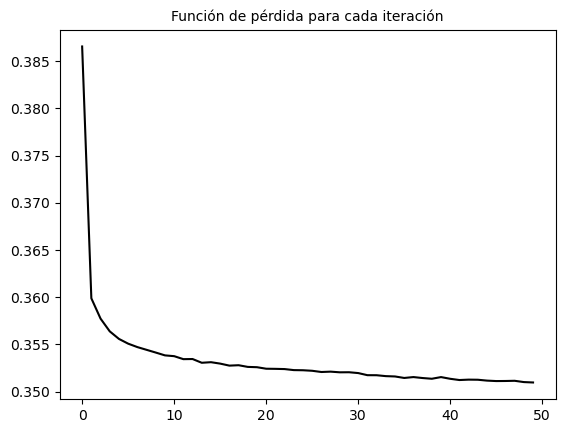

In [22]:
plt.figure()

plt.plot(results.history["loss"], color="black")

plt.title("Función de pérdida para cada iteración", fontsize = 10)

plt.savefig("./figures/loss-function.pdf")
plt.show()

### Modelo 7. Support Vector Machine

In [23]:
# Grid Search:
svm_grid_search = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1],
    'kernel': ['rbf'],
    'probability': [True], # Para predict_proba
    'random_state': [19]
}

grid = GridSearchCV(
    svm_grid_search, param_grid, cv = 5, scoring = "accuracy",
    verbose = 10, n_jobs = -1
)

svm = grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [24]:
print(svm.best_params_)
print(svm.best_score_ )

{'C': 1, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 19}
0.8473593410715564


In [25]:
yhat_proba_svm = svm.predict_proba(X_test)[:,1]
yhat_svm = svm.predict(X_test)

# Estadisticos
score_svm = accuracy_score(y_test, yhat_svm)
ps_svm = precision_score(y_test, yhat_svm)
r_svm = recall_score(y_test, yhat_svm)
f1_svm = f1_score(y_test, yhat_svm)

# Confusion matrix y ROC
conf_svm = confusion_matrix(y_test, yhat_svm, normalize="true")
report_svm = classification_report(y_test, yhat_svm)
fsvm, tsvm, thresholds = roc_curve(y_test, yhat_proba_svm)

print(report_svm)

              precision    recall  f1-score   support

         0.0       0.61      0.21      0.31      2708
         1.0       0.86      0.97      0.91     13373

    accuracy                           0.84     16081
   macro avg       0.74      0.59      0.61     16081
weighted avg       0.82      0.84      0.81     16081



### Modelo 8. XGBoost

In [26]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric = "mlogloss", random_state = 19).fit(X_train, y_train)

yhat_proba_xgb = xgb.predict_proba(X_test)[:,1]
yhat_xgb = xgb.predict(X_test)

# Estadisticos
score_xgb = accuracy_score(y_test, yhat_xgb)
ps_xgb = precision_score(y_test, yhat_xgb)
r_xgb = recall_score(y_test, yhat_xgb)
f1_xgb = f1_score(y_test, yhat_xgb)

# Confusion matrix y ROC
conf_xgb = confusion_matrix(y_test, yhat_xgb, normalize="true")
report_xgb = classification_report(y_test, yhat_xgb)
fxgb, txgb, thresholds = roc_curve(y_test, yhat_proba_xgb)

print(report_xgb)

              precision    recall  f1-score   support

         0.0       0.64      0.32      0.43      2708
         1.0       0.87      0.96      0.92     13373

    accuracy                           0.85     16081
   macro avg       0.76      0.64      0.67     16081
weighted avg       0.83      0.85      0.83     16081



### Modelo 9. Naive Bayes

In [28]:
nb_grid_search = GaussianNB()

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

grid = GridSearchCV(
    nb_grid_search, param_grid, cv = 5, scoring = "accuracy", 
    verbose = 10, n_jobs = -1
)

nb = grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [29]:
print(nb.best_params_)
print(nb.best_score_ )

{'var_smoothing': 1.0}
0.8310505019596924


In [30]:
yhat_proba_nb = nb.predict_proba(X_test)[:,1]
yhat_nb = nb.predict(X_test)

# Estadisticos
score_nb = accuracy_score(y_test, yhat_nb)
ps_nb = precision_score(y_test, yhat_nb)
r_nb = recall_score(y_test, yhat_nb)
f1_nb = f1_score(y_test, yhat_nb)

# Confusion matrix y ROC
conf_nb = confusion_matrix(y_test, yhat_nb, normalize="true")
report_nb = classification_report(y_test, yhat_nb)
fnb, tnb, thresholds = roc_curve(y_test, yhat_proba_nb)

print(report_nb)

              precision    recall  f1-score   support

         0.0       0.48      0.39      0.43      2708
         1.0       0.88      0.92      0.90     13373

    accuracy                           0.83     16081
   macro avg       0.68      0.65      0.66     16081
weighted avg       0.81      0.83      0.82     16081



### Comparativa entre modelos

In [31]:
# 1. Indicadores de ajuste en testing
dict_ajust = {
    "Regresión lineal": score_ml,
    "Regresión logistica": score_lr,
    "KNN": score_knn,
    "Decision tree": score_tree,
    "Random forest": score_rf,
    "Neural networks": score_nn,
    "SVM": score_svm,
    "XGBoost": score_xgb,
    "Naive Bayes": score_nb
}

df_score = pd.DataFrame(dict_ajust.items(), columns=["Modelo", "Score"]).set_index("Modelo")
df_score["Score"] = np.round(df_score["Score"], 3)
df_score = df_score.sort_values("Score", ascending=False)

df_score

,Score
Modelo,
XGBoost,0.855
Decision tree,0.847
Random forest,0.845
SVM,0.845
Neural networks,0.843
Regresión logistica,0.841
KNN,0.840
Regresión lineal,0.837
Naive Bayes,0.827


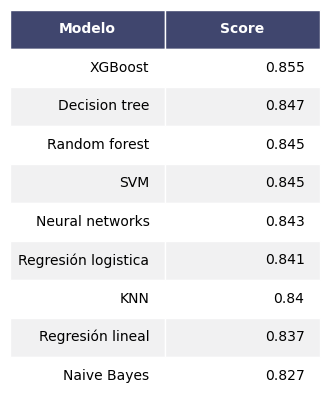

In [32]:
fig, ax = utils.render_mpl_table(df_score.reset_index(), header_columns=0, col_width=2.0)
fig.savefig("./figures/score.png")

In [33]:
# 2. Precision
dict_precision = {
    "Regresión lineal": ps_ml,
    "Regresión logistica": ps_lr,
    "KNN": ps_knn,
    "Decision tree": ps_tree,
    "Random forest": ps_rf,
    "Neural networks": ps_nn,
    "SVM": ps_svm,
    "XGBoost": ps_xgb,
    "Naive Bayes": ps_nb
}

df_precision = pd.DataFrame(dict_precision.items(), columns=["Modelo", "Precision"]).set_index("Modelo")
df_precision["Precision"] = np.round(df_precision["Precision"], 3)
df_precision = df_precision.sort_values("Precision", ascending=False)

df_precision

,Precision
Modelo,
Naive Bayes,0.881
XGBoost,0.875
Decision tree,0.873
Neural networks,0.869
KNN,0.864
Random forest,0.860
SVM,0.859
Regresión logistica,0.857
Regresión lineal,0.843


In [34]:
# 3. Recall
dict_recall = {
    "Regresión lineal": r_ml,
    "Regresión logistica": r_lr,
    "KNN": r_knn,
    "Decision tree": r_tree,
    "Random forest": r_rf,
    "Neural networks": r_nn,
    "SVM": r_svm,
    "XGBoost": r_xgb,
    "Naive Bayes": r_nb
}

df_recall = pd.DataFrame(dict_recall.items(), columns=["Modelo", "Recall"]).set_index("Modelo")
df_recall["Recall"] = np.round(df_recall["Recall"], 3)
df_recall = df_recall.sort_values("Recall", ascending=False)

df_recall

,Recall
Modelo,
Regresión lineal,0.989
SVM,0.973
Random forest,0.972
Regresión logistica,0.971
XGBoost,0.963
KNN,0.959
Decision tree,0.956
Neural networks,0.955
Naive Bayes,0.917


In [35]:
# 4. F1-Score
dict_f1 = {
    "Regresión lineal": f1_ml,
    "Regresión logistica": f1_lr,
    "KNN": f1_knn,
    "Decision tree": f1_tree,
    "Random forest": f1_rf,
    "Neural networks": f1_nn,
    "SVM": f1_svm,
    "XGBoost": f1_xgb,
    "Naive Bayes": f1_nb
}

df_f1 = pd.DataFrame(dict_f1.items(), columns=["Modelo", "F1-Score"]).set_index("Modelo")
df_f1["F1-Score"] = np.round(df_f1["F1-Score"], 3)
df_f1 = df_f1.sort_values("F1-Score", ascending=False)

df_f1

,F1-Score
Modelo,
XGBoost,0.917
Random forest,0.913
Decision tree,0.912
SVM,0.912
Regresión logistica,0.911
Regresión lineal,0.910
Neural networks,0.910
KNN,0.909
Naive Bayes,0.898


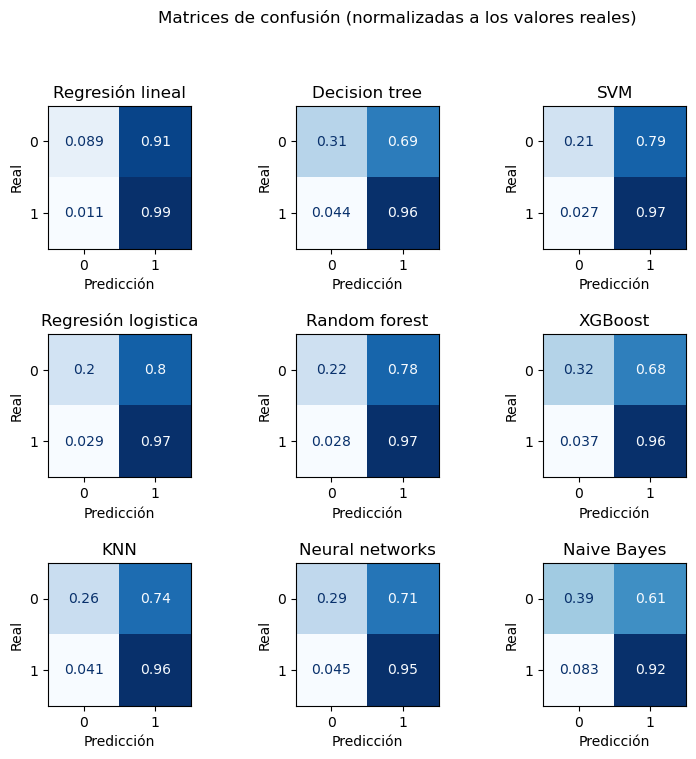

In [36]:
# 5. Matriz de confusion
dict_conf = {
    "Regresión lineal": conf_ml,
    "Regresión logistica": conf_lr,
    "KNN": conf_knn,
    "Decision tree": conf_tree,
    "Random forest": conf_rf,
    "Neural networks": conf_nn,
    "SVM": conf_svm,
    "XGBoost": conf_xgb,
    "Naive Bayes": conf_nb
}

conf_names = list(dict_conf.keys())
conf_matrixes = dict_conf.values()


# Figura
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

r = 0; c = 0; i = 0

for matrix in conf_matrixes:
    fig = ConfusionMatrixDisplay(
        confusion_matrix = matrix,
    ).plot(ax = ax[r, c], colorbar = False, cmap=plt.cm.Blues)
    
    ax[r, c].set_title(conf_names[i])
    ax[r, c].set_xlabel("Predicción")
    ax[r, c].set_ylabel("Real")
    
    i += 1
    r += 1
    if r == 3:
        c += 1
        r = 0
    else:
        pass

plt.suptitle("Matrices de confusión (normalizadas a los valores reales)")
plt.subplots_adjust(top=0.9, bottom=0.4, left=0.2, right=0.75, hspace=0.6, wspace=0.5)

plt.savefig("./figures/matrices_confusion.pdf", bbox_inches="tight", transparent=True)
plt.show()

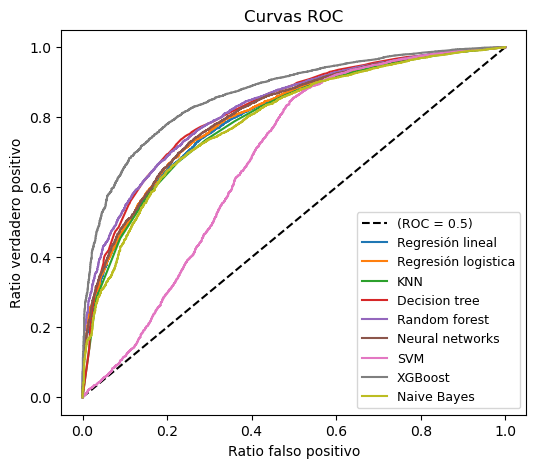

In [37]:
# 6. ROC
dict_conf = {
    "Regresión lineal": [fml, tml],
    "Regresión logistica": [flr, tlr],
    "KNN": [fknn, tknn],
    "Decision tree": [ftree, ttree],
    "Random forest": [frf, trf],
    "Neural networks": [fnn, tnn],
    "SVM": [fsvm, tsvm],
    "XGBoost": [fxgb, txgb],
    "Naive Bayes": [fnb, tnb]
}
keys = list(dict_conf.keys())
values = list(dict_conf.values())


# Figura
plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], "k--", label="(ROC = 0.5)")

j = 0
for i in values:
    plt.plot(i[0], i[1], label=keys[j])
    j += 1

plt.xlabel("Ratio falso positivo")
plt.ylabel("Ratio verdadero positivo")
plt.title("Curvas ROC")
plt.legend(fontsize=9)

plt.savefig("./figures/roc.pdf", bbox_inches="tight", transparent=True)
plt.savefig("./figures/roc.png", bbox_inches="tight", transparent=True)
plt.show()